### Numbers Game

In [1]:
# A smaller version of Json Tenebaum's Number Game
# The source of the code is https://github.com/probml/pyprobml/blob/master/scripts/knn_classify_demo.py

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

# The range of numbers to be considered: [1,...,100]
number_range = np.arange(1, 101)

In [105]:
# A hypothesis is represented by a name and predicate.
# The predicate can be used to verify whether one element is in the hypothesis space
class Hypothesis:
    def __init__(self, predicate, name):
        self.predicate = predicate
        self.name = name
        
        # the extension of the hypothesis
        self.extension = [n for n in number_range if self.predicate(n)]
        # the size of the extension of this hypothesis
        self.size = len(self.extension)
        
    # Returns the extension of the hypothesis as a list of binary indicators for each
    # of the numbers in the number range. Note: the first indicator value corresponds
    # to the first number in the range of numbers, etc.
    def get_extension_indication(self):
        return [int(self.predicate(x)) for x in number_range]
        
    # Returns two hypotheses: the even numbers, and the odd numbers
    @staticmethod
    def even_odd():
        even = Hypothesis(lambda x: x % 2 == 0, "even")
        odd = Hypothesis(lambda x: x % 2 != 0, "odd")
        return [even, odd]
    
    # Return array of hypotheses based on the provided the multipliers
    @staticmethod
    def multiples(multipliers):
        return [Hypothesis(lambda x: x % m == 0, f"mult of {m}") for m in multipliers]
    
    # Return array of hypotheses based on the provided digits. The numbers in each extension
    # should end in the corresponding digit
    @staticmethod
    def ending_in(digits):
        return [Hypothesis(lambda x: x % 10 == d, f"ends in {d}") for d in digits]
    
    # Return array of hypotheses based on the provided bases. The numbers in each extension
    # should be the positive integer power of the base    
    @staticmethod
    def powers(bases):
        return [Hypothesis(lambda x: Hypothesis._is_power(x, b), f"powers of {b}") for b in bases]
    
    # Helper function to check whether x is the power of base
    @staticmethod
    def _is_power(x, base):
        curr = base
        while curr < x:
            curr = curr * base
        return curr == x
    
    # Return array of hypotheses whose extension should be included in the provided integers
    @staticmethod
    def explicit_set(numbers):
        return [Hypothesis(lambda x: x in numbers, "{"+",".join([str(n) for n in numbers])+"}")]
    
    # The probabilty under this hypothesis of generating the given number
    # equation: π(n ε h)/|h|
    def prob(self, number):
        return int(self.predicate(number)) / self.size
    
    # This function pairwise composes twe lists of hypotheses of the same length into a single
    # list of that length
    @staticmethod
    def compose(first_hypotheses, second_hypotheses, operation, operation_name):
        return [
            Hypothesis(
                lambda x: operation(
                    first_hypotheses[i].predicate(x), second_hypotheses[i].predicate(x)
                ),
                f"{first_hypotheses[i].name} {operation_name} {second_hypotheses[i].name}"
            ) for i in range(0, len(first_hypotheses))
        ]

In [82]:
# A Bayes class contains the method the method to calculate the likelihood, prior, posterior
class Bayes:
    # Calculate the likelihood, P(D|h) = 1 / pow(|h|, len(D))
    # Returns vector L, s.t L[i] = P(D|h[i])        
    @staticmethod
    def likelihood(data, hypotheses):
        lik = np.column_stack([[hypothesis.prob(x) for x in data] for hypothesis in hypotheses])
        return np.prod(lik, 0)
    
    # posterior distribution 
    # equation: P(h/D) = P(h) * P(D|h) / P(D)
    # data is same in likelihood, the hypotheses are different
    def posterior(prior, likelihood):
        post = prior * likelihood
        return post / sum(post)

In [106]:
# A class to draw the plot 
class Graphing:
    @staticmethod
    def plot_hypothesis_space(hypotheses):
        image = np.column_stack([hypothesis.get_extension_indication() for hypothesis in hypotheses])
        
        plt.gray()
        plt.xticks([i for i in range(len(hypotheses))], [hypothesis.name for hypothesis in hypotheses], rotation='vertical')
        plt.yticks([0, 20, 40, 60, 80, 100])
        # Ensure the 100 label is shown.
        plt.ylim(-1, 100)
        plt.imshow(image, aspect='auto', interpolation='none', origin='lower')
        
        # Don't block, continue to show the next figure.
        plt.show(block=False)

In [109]:
# The hypothesis space: a vector of hypotheses
hypotheses = Hypothesis.even_odd() \
    + [Hypothesis(lambda x: x == np.floor(0.5 + np.sqrt(x)) ** 2, "squares")] \
    + Hypothesis.multiples(np.arange(3, 11)) \
    + Hypothesis.ending_in(np.arange(1, 10)) \
    + Hypothesis.powers(np.arange(2, 11)) \
    + [Hypothesis(lambda x: True, "all")] \
    + Hypothesis.compose(Hypothesis.powers([2]), Hypothesis.explicit_set([37]), lambda x, y: x or y, "+") \
    + Hypothesis.compose(Hypothesis.powers([2]), Hypothesis.explicit_set([32]), lambda x, y: x and not y, "-")

# The prior on the hypothesis space
# {odd, even} = 0.5; {powers of 2 + 37, powers of 2 - 32} = 0.001, else=0.1 
prior = np.concatenate([np.array([0.5, 0.5]), 0.1 * np.ones(28), np.array([0.001, 0.001])])
prior = prior / sum(prior)

# Calculations for D={16}
data_16 = [16]
likelihood_16 = Bayes.likelihood(data_16, hypotheses)
posterior_16 = Bayes.posterior(prior, likelihood_16)
display(posterior_16)

# Calculations for D={16, 8, 2, 64}
data_all = [16, 8, 2, 64]
likelihood_all = Bayes.likelihood(data_all, hypotheses)
posterior_all = Bayes.posterior(prior, likelihood_all)
display(posterior_all)

array([0.46854083, 0.        , 0.46854083, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04685408,
       0.00669344, 0.00937082])

array([3.81407686e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.76759607e-04, 1.98567100e-01, 7.62815372e-01])

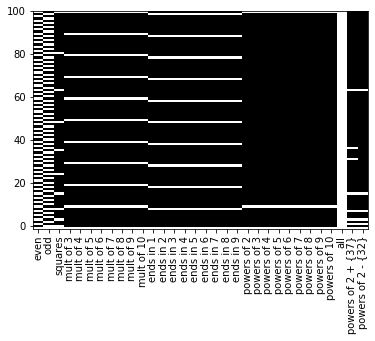

In [108]:
Graphing.plot_hypothesis_space(hypotheses)